In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2

from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
import albumentations

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from torchmetrics import F1
from pytorch_toolbelt import losses as L
import timm

from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.optim.lr_scheduler import StepLR, MultiStepLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from pytorch_lightning.callbacks import ModelCheckpoint 
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler

from pytorch_toolbelt import losses as L

gpu = 1 if torch.cuda.is_available() else 0
print(f'Using {gpu} GPUS')


import warnings
warnings.filterwarnings('ignore')

Using 1 GPUS


In [2]:
root_path = '/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/datasets/'
print(os.listdir(root_path))

['Eucalyptus sp.', 'Brassica', 'Taraxacum', 'Rosmarinus officinalis', 'Tilia', 'Erica.m', 'Lavandula', 'Cistus sp', 'Pinus', 'Cardus', 'Citrus sp', 'Helianthus annuus']


In [3]:
df_train = pd.read_csv('List_train.csv')
df_val = pd.read_csv('List_val.csv')
df_test = pd.read_csv('List_test.csv')

In [4]:
count_train = df_train.groupby('labels').agg({'count'})
count_train['weights'] = 1.02/count_train['name']
count_train['weights_norm'] = count_train['weights']/count_train['weights'].sum()
# count_train['weights_nor'].sum()
count_train

,Unnamed: 0,name,weights,weights_norm
,count,count,,
labels,,,,
Brassica,1198,1198,0.000851,0.029288
Cardus,161,161,0.006335,0.217930
Cistus sp,589,589,0.001732,0.059570
Citrus sp,447,447,0.002282,0.078494
Erica.m,1576,1576,0.000647,0.022263
Eucalyptus sp.,807,807,0.001264,0.043478
Helianthus annuus,780,780,0.001308,0.044983
Lavandula,636,636,0.001604,0.055168


In [5]:
# self.classes = ['Pinus','Erica.m', 'Cistus sp', 'Lavandula', 'Citrus sp', 'Helianthus annuus',
#                 'Eucalyptus sp.', 'Rosmarinus officinalis', 'Brassica', 'Cardus', 'Tilia', 'Taraxacum']
class_weights=torch.Tensor([count_train.loc['Pinus','weights_norm'].item(),
                      count_train.loc['Erica.m','weights_norm'].item(),
                      count_train.loc['Cistus sp','weights_norm'].item(),
                      count_train.loc['Lavandula','weights_norm'].item(),
                      count_train.loc['Citrus sp','weights_norm'].item(),
                      count_train.loc['Helianthus annuus','weights_norm'].item(),
                      count_train.loc['Eucalyptus sp.','weights_norm'].item(),
                      count_train.loc['Rosmarinus officinalis','weights_norm'].item(),
                      count_train.loc['Brassica','weights_norm'].item(),
                      count_train.loc['Cardus','weights_norm'].item(),
                      count_train.loc['Tilia','weights_norm'].item(),
                      count_train.loc['Taraxacum','weights_norm'].item(),
                      ])
class_weights

tensor([0.1456, 0.0223, 0.0596, 0.0552, 0.0785, 0.0450, 0.0435, 0.0790, 0.0293,
        0.2179, 0.0610, 0.1632])

## Weighted Sampler

In [6]:


samples_weight = np.array([count_train.loc[t,'weights_norm'].item() for t in df_train['labels']])
samples_weight=torch.from_numpy(samples_weight)

print(samples_weight.shape)

sampler = WeightedRandomSampler(samples_weight, len(samples_weight))


torch.Size([7669])


In [7]:
# From https://juansensio.com/blog/062_multihead_attention
class Dataset(torch.utils.data.Dataset):
    def __init__(self, mode, df):
        self.mode = mode
        self.df = df 
        self.mean_img = (0.485, 0.456, 0.406 )
        self.std_img = (0.229, 0.224, 0.225)
        self.classes = ['Pinus','Erica.m', 'Cistus sp', 'Lavandula', 'Citrus sp', 'Helianthus annuus',
                        'Eucalyptus sp.', 'Rosmarinus officinalis', 'Brassica', 'Cardus', 'Tilia', 'Taraxacum']
    def __crop_padding(self,img):
        ## convert to gray
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ## set threshold for 0
        _,thresh = cv2.threshold(img_gray,10,255,cv2.THRESH_BINARY)
        ## find contours
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        cnt = contours[0]
        x,y,w,h = cv2.boundingRect(cnt)
        crop = img[y:y+h,x:x+w,:]
        return crop
    def __getitem__(self, index):
        name_img = self.df['name'].iloc[index]
        label    = self.df['labels'].iloc[index]
        ## READ IMAGE
        image = plt.imread(name_img)
        image = self.__crop_padding(image)
        target = torch.tensor(self.classes.index(label))
        # print(f'Image shape: {image.shape} \t Target:{target}')
        if self.mode=='train':
            train_augm = albumentations.Compose(
              [
               albumentations.Resize(height=320,width=320),
               albumentations.Normalize(self.mean_img, self.std_img, max_pixel_value=255.0, always_apply=True),
              #  albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15),
              #  albumentations.Flip(p=0.5)
              ]
            )
            transformed = train_augm(image=image)
            image=transformed['image']
        else:
            valid_augm = albumentations.Compose(
              [
               albumentations.Resize(height=320,width=320),
               albumentations.Normalize(self.mean_img, self.std_img, max_pixel_value=255.0, always_apply=True)
              ]
            )
            transformed = valid_augm(image=image)
            image=transformed['image']
        image = torch.from_numpy(image.transpose()).float()
        target_oh = torch.nn.functional.one_hot(target, num_classes=12).float()
        data = {"image":image,
                "target_oh":target_oh,
                'target':target,
                'class_name':label } 
        # print(f'Image shape: {image.shape} \t Target:{target}')
        return data
    def __len__(self):
        return len(self.df)

class HoneyDataModule(pl.LightningDataModule):
    def __init__(self, batch_size: int = 4, Dataset = Dataset):
        super().__init__()
        self.batch_size = batch_size
        self.Dataset = Dataset
        self.train_ds =  self.Dataset(mode='train',df= df_train)
        self.val_ds   =  self.Dataset(mode='val', df= df_val)
        self.test_ds   =  self.Dataset(mode='test', df= df_test)
    def train_dataloader(self):
        return DataLoader(self.train_ds,
                          batch_size=4,
                          # shuffle=True,
                          num_workers=0,
                          pin_memory=True,
                          drop_last=True,
                          sampler=sampler
                          )
    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=4, shuffle=False, num_workers=0, pin_memory=True, drop_last=True )
    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True, drop_last=False )
    
dm = HoneyDataModule(Dataset=Dataset)

In [8]:
from torchmetrics import MatthewsCorrcoef as MCC
from torchmetrics import AUROC

In [38]:
val_epoch_loss_CE, val_epoch_acc_CE = [], []
train_epoch_loss_CE, train_epoch_acc_CE = [], []

class LitModel_Focal(pl.LightningModule):
    def __init__(self, model):
        super().__init__( )
        # self.save_hyperparameters()
        self.model = model
        # self.class_weights=class_weights.to('cuda')
        self.focal_loss = L.FocalLoss(alpha=0.25, gamma=2)
        # self.class_weights
        self.f1_score = F1(num_classes=12,average='weighted')
        # self.mcc = MCC(num_classes=12)
        # self.auroc = AUROC(num_classes=12,average='weighted')
        
        
    def forward(self, x):
        return self.model(x)
    def predict(self, x):
        with torch.no_grad():
            y_hat = self(x)
            return y_hat
            # return torch.argmax(y_hat, axis=1)
    def compute_loss_and_metrics(self, batch):
        x, y = batch['image'], batch['target']
        # print(f'X: {x.shape} \t Y: {y.shape}')
        y_hat = self(x)
        # print(f'Output: {y_hat.shape}')
        # loss = F.cross_entropy(y_hat, y, weight=self.class_weights)
        loss = self.focal_loss(y_hat, y)
        # acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        # y1 = y.detach().cpu().numpy()
        # # print(y1.shape)
        # mcc = self.mcc(y_hat, y)
        # auroc = self.auroc(y_hat, y)
        y_hat1 = torch.argmax(y_hat, axis=1)
        # y_hat1 = y_hat1.detach().cpu().numpy()
        # print(y_hat1.shape)
        f1w = self.f1_score( y, y_hat1)#, average='weighted')
        return loss, f1w#, mcc, auroc
    def training_step(self, batch, batch_idx):
        loss, f1w = self.compute_loss_and_metrics(batch)
        self.log('train_loss', loss)
        self.log('train_F1w', f1w, prog_bar=True)
        # self.log('train_mcc', mcc, prog_bar=True)
        # self.log('train_auroc', auroc, prog_bar=True)
        #print(f'Training_step: loss> {loss} acc:{acc}')
        return {'loss':loss,'f1w':torch.tensor(f1w)}#, 'mcc':torch.tensor(mcc), 'auroc':torch.tensor(auroc)}
    
    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_train_f1w  = torch.stack([x['f1w'] for x in outputs]).mean()
        # avg_train_mcc  = torch.stack([x['mcc'] for x in outputs]).mean()
        # avg_train_auroc  = torch.stack([x['auroc'] for x in outputs]).mean()

        train_epoch_loss_CE.append(avg_train_loss.item())
        train_epoch_acc_CE.append(avg_train_f1w.item())
        #print(f'Epoch {self.current_epoch} TrainLOSS:{avg_train_loss} TrainACC:{avg_train_acc}  ')
    def validation_step(self, batch, batch_idx):
        loss, f1w= self.compute_loss_and_metrics(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_f1w', f1w, prog_bar=True)
        # self.log('val_mcc', mcc, prog_bar=True)
        # self.log('val_auroc', auroc, prog_bar=True)
        
        return {'val_loss': torch.tensor(loss.item()), 'val_f1w': torch.tensor(f1w)}#, 'val_mcc': torch.tensor(mcc), 'val_auroc': torch.tensor(auroc) }
    def validation_epoch_end(self, outputs):
        avg_val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_val_f1w  = torch.stack([x['val_f1w'] for x in outputs]).mean()
        # avg_val_mcc  = torch.stack([x['val_mcc'] for x in outputs]).mean()
        # avg_val_auroc  = torch.stack([x['val_auroc'] for x in outputs]).mean()
        
        self.log('EarlyStop_Log', avg_val_loss.detach(), on_epoch=True, sync_dist=True)
        self.log('avg_val_f1w', avg_val_f1w.detach(), on_epoch=True, sync_dist=True)
        # self.log('avg_val_mcc', avg_val_mcc.detach(), on_epoch=True, sync_dist=True)
        # self.log('avg_val_auroc', avg_val_auroc.detach(), on_epoch=True, sync_dist=True)
        
        val_epoch_loss_CE.append(avg_val_loss.item())
        val_epoch_acc_CE.append(avg_val_f1w.item())
        #print(f'VAL-Epoch {self.current_epoch} LOSS:{avg_val_loss} ACC:{avg_val_acc} ')
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                                                    T_0=10,
                                                                    T_mult=1,
                                                                    eta_min=1e-7,
                                                                    verbose=True,
                                                                    )

        # lr_scheduler = {'scheduler': MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.5,),'interval': 'epoch','frequency':1}
        return [optimizer], [lr_scheduler]

## Probando EfficientNet

In [14]:
# timm.list_models(pretrained=True)
eff_model = timm.create_model('tf_efficientnet_b7',pretrained='True',num_classes=12)


In [15]:
eff_model_focal_sampler  = LitModel_Focal(model=eff_model)


In [16]:
checkpoint_callback = ModelCheckpoint(dirpath='/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/', 
                                      filename='EffB7-Focal-Sampler-{epoch}-{val_loss:.2f}-{avg_val_f1w:.2f}',
                                      monitor='avg_val_f1w',
                                      verbose=True,
                                      save_last=None,
                                      save_top_k=1,
                                      save_weights_only=False,
                                      mode='max',
                                      auto_insert_metric_name=True,
                                      )


early_stop_callback = EarlyStopping(monitor='EarlyStop_Log',\
                                    min_delta=0.00,\
                                    patience=5,\
                                    verbose=False,\
                                    mode='min')
    

## Sanity-check
trainer = pl.Trainer(gpus=gpu,
                     callbacks=[checkpoint_callback,
                                # early_stop_callback,
                               ],
                    #  deterministic=True,
                     enable_progress_bar=True,
                    #  progress_bar_
                    #  limit_train_batches=2,
                    #  limit_val_batches=2,
                     max_epochs=20)

# Then you call the fit method passing the PL-module and PL-Datamodule, to start training.
trainer.fit(eff_model_focal_sampler, dm)



    

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name       | Type         | Params
--------------------------------------------
0 | model      | EfficientNet | 63.8 M
1 | focal_loss | FocalLoss    | 0     
2 | f1_score   | F1           | 0     
--------------------------------------------
63.8 M    Trainable params
0         Non-trainable params
63.8 M    Total params
255.271   Total estimated model params size (MB)


Epoch     0: adjusting learning rate of group 0 to 1.0000e-04.
Epoch 0:  95%|█████████▍| 1917/2018 [07:22<00:23,  4.33it/s, loss=0.0503, v_num=1666580, train_F1w=1.000]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 2018/2018 [07:29<00:00,  4.49it/s, loss=0.0503, v_num=1666580, train_F1w=1.000, val_loss=0.0343, val_f1w=0.967]

Epoch 0, global step 1916: avg_val_f1w reached 0.96700 (best 0.96700), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/EffB7-Focal-Sampler-epoch=0-val_loss=0.03-avg_val_f1w=0.97-v1.ckpt" as top 1


Epoch 1:  95%|█████████▌| 1918/2018 [07:21<00:23,  4.35it/s, loss=0.0258, v_num=1666580, train_F1w=1.000, val_loss=0.0343, val_f1w=0.967]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 2018/2018 [07:28<00:00,  4.50it/s, loss=0.0258, v_num=1666580, train_F1w=1.000, val_loss=0.0514, val_f1w=0.953]

Epoch 1, global step 3833: avg_val_f1w was not in top 1


Epoch 2:  95%|█████████▌| 1918/2018 [07:20<00:22,  4.35it/s, loss=0.02, v_num=1666580, train_F1w=1.000, val_loss=0.0514, val_f1w=0.953]  
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 2018/2018 [07:28<00:00,  4.50it/s, loss=0.02, v_num=1666580, train_F1w=1.000, val_loss=0.0324, val_f1w=0.970]

Epoch 2, global step 5750: avg_val_f1w reached 0.97030 (best 0.97030), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/EffB7-Focal-Sampler-epoch=2-val_loss=0.03-avg_val_f1w=0.97.ckpt" as top 1


Epoch 3:  95%|█████████▌| 1918/2018 [07:21<00:23,  4.35it/s, loss=0.00426, v_num=1666580, train_F1w=1.000, val_loss=0.0324, val_f1w=0.970]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 2018/2018 [07:28<00:00,  4.50it/s, loss=0.00426, v_num=1666580, train_F1w=1.000, val_loss=0.0133, val_f1w=0.988]

Epoch 3, global step 7667: avg_val_f1w reached 0.98845 (best 0.98845), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/EffB7-Focal-Sampler-epoch=3-val_loss=0.01-avg_val_f1w=0.99.ckpt" as top 1


Epoch 4:  95%|█████████▌| 1918/2018 [07:21<00:23,  4.35it/s, loss=0.0171, v_num=1666580, train_F1w=1.000, val_loss=0.0133, val_f1w=0.988]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 2018/2018 [07:28<00:00,  4.50it/s, loss=0.0171, v_num=1666580, train_F1w=1.000, val_loss=0.0135, val_f1w=0.993]

Epoch 4, global step 9584: avg_val_f1w reached 0.99340 (best 0.99340), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/EffB7-Focal-Sampler-epoch=4-val_loss=0.01-avg_val_f1w=0.99.ckpt" as top 1


Epoch 5:  95%|█████████▌| 1918/2018 [07:21<00:23,  4.34it/s, loss=0.000535, v_num=1666580, train_F1w=1.000, val_loss=0.0135, val_f1w=0.993]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 2018/2018 [07:28<00:00,  4.49it/s, loss=0.000535, v_num=1666580, train_F1w=1.000, val_loss=0.0113, val_f1w=0.993]

Epoch 5, global step 11501: avg_val_f1w was not in top 1


Epoch 6:  95%|█████████▌| 1918/2018 [07:21<00:23,  4.34it/s, loss=0.00309, v_num=1666580, train_F1w=1.000, val_loss=0.0113, val_f1w=0.993]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 2018/2018 [07:28<00:00,  4.49it/s, loss=0.00309, v_num=1666580, train_F1w=1.000, val_loss=0.0112, val_f1w=0.993]

Epoch 6, global step 13418: avg_val_f1w was not in top 1


Epoch 7:  95%|█████████▌| 1918/2018 [07:21<00:23,  4.34it/s, loss=0.000588, v_num=1666580, train_F1w=1.000, val_loss=0.0112, val_f1w=0.993]
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 2018/2018 [07:29<00:00,  4.49it/s, loss=0.000588, v_num=1666580, train_F1w=1.000, val_loss=0.00996, val_f1w=0.993]

Epoch 7, global step 15335: avg_val_f1w was not in top 1


Epoch 8:  95%|█████████▌| 1918/2018 [07:21<00:23,  4.34it/s, loss=0.0121, v_num=1666580, train_F1w=1.000, val_loss=0.00996, val_f1w=0.993]
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 2018/2018 [07:28<00:00,  4.50it/s, loss=0.0121, v_num=1666580, train_F1w=1.000, val_loss=0.0111, val_f1w=0.993]

Epoch 8, global step 17252: avg_val_f1w was not in top 1


Epoch 9:  95%|█████████▌| 1918/2018 [07:22<00:23,  4.34it/s, loss=0.000218, v_num=1666580, train_F1w=1.000, val_loss=0.0111, val_f1w=0.993]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 2018/2018 [07:29<00:00,  4.49it/s, loss=0.000218, v_num=1666580, train_F1w=1.000, val_loss=0.00887, val_f1w=0.991]

Epoch 9, global step 19169: avg_val_f1w was not in top 1


Epoch 10:  95%|█████████▌| 1918/2018 [07:21<00:23,  4.34it/s, loss=0.0141, v_num=1666580, train_F1w=1.000, val_loss=0.00887, val_f1w=0.991]
Validating: 0it [00:00, ?it/s]
Epoch 10: 100%|██████████| 2018/2018 [07:29<00:00,  4.49it/s, loss=0.0141, v_num=1666580, train_F1w=1.000, val_loss=0.0153, val_f1w=0.976]

Epoch 10, global step 21086: avg_val_f1w was not in top 1


Epoch 11:  95%|█████████▌| 1918/2018 [07:21<00:23,  4.34it/s, loss=0.0219, v_num=1666580, train_F1w=0.667, val_loss=0.0153, val_f1w=0.976]
Validating: 0it [00:00, ?it/s]
Epoch 11: 100%|██████████| 2018/2018 [07:28<00:00,  4.49it/s, loss=0.0219, v_num=1666580, train_F1w=0.667, val_loss=0.0204, val_f1w=0.979]

Epoch 11, global step 23003: avg_val_f1w was not in top 1


Epoch 12:  95%|█████████▌| 1918/2018 [07:21<00:23,  4.34it/s, loss=0.0104, v_num=1666580, train_F1w=1.000, val_loss=0.0204, val_f1w=0.979]
Validating: 0it [00:00, ?it/s]
Epoch 12: 100%|██████████| 2018/2018 [07:28<00:00,  4.50it/s, loss=0.0104, v_num=1666580, train_F1w=1.000, val_loss=0.0124, val_f1w=0.988]

Epoch 12, global step 24920: avg_val_f1w was not in top 1


Epoch 13:  95%|█████████▌| 1918/2018 [07:21<00:23,  4.34it/s, loss=0.00128, v_num=1666580, train_F1w=1.000, val_loss=0.0124, val_f1w=0.988]
Validating: 0it [00:00, ?it/s]
Epoch 13: 100%|██████████| 2018/2018 [07:28<00:00,  4.50it/s, loss=0.00128, v_num=1666580, train_F1w=1.000, val_loss=0.0109, val_f1w=0.989]

Epoch 13, global step 26837: avg_val_f1w was not in top 1


Epoch 14:  95%|█████████▌| 1918/2018 [07:21<00:23,  4.34it/s, loss=0.00298, v_num=1666580, train_F1w=1.000, val_loss=0.0109, val_f1w=0.989]
Validating: 0it [00:00, ?it/s]
Epoch 14: 100%|██████████| 2018/2018 [07:28<00:00,  4.49it/s, loss=0.00298, v_num=1666580, train_F1w=1.000, val_loss=0.0139, val_f1w=0.993]

Epoch 14, global step 28754: avg_val_f1w was not in top 1


Epoch 15:  95%|█████████▌| 1918/2018 [07:21<00:23,  4.34it/s, loss=0.00953, v_num=1666580, train_F1w=1.000, val_loss=0.0139, val_f1w=0.993]
Validating: 0it [00:00, ?it/s]
Epoch 15: 100%|██████████| 2018/2018 [07:28<00:00,  4.49it/s, loss=0.00953, v_num=1666580, train_F1w=1.000, val_loss=0.0318, val_f1w=0.985]

Epoch 15, global step 30671: avg_val_f1w was not in top 1


Epoch 16:  95%|█████████▌| 1918/2018 [07:21<00:23,  4.34it/s, loss=2.99e-05, v_num=1666580, train_F1w=1.000, val_loss=0.0318, val_f1w=0.985]
Validating: 0it [00:00, ?it/s]
Epoch 16: 100%|██████████| 2018/2018 [07:28<00:00,  4.50it/s, loss=2.99e-05, v_num=1666580, train_F1w=1.000, val_loss=0.0126, val_f1w=0.993]

Epoch 16, global step 32588: avg_val_f1w was not in top 1


Epoch 17:  95%|█████████▌| 1918/2018 [07:21<00:23,  4.34it/s, loss=0.000986, v_num=1666580, train_F1w=1.000, val_loss=0.0126, val_f1w=0.993]
Validating: 0it [00:00, ?it/s]
Epoch 17: 100%|██████████| 2018/2018 [07:29<00:00,  4.49it/s, loss=0.000986, v_num=1666580, train_F1w=1.000, val_loss=0.015, val_f1w=0.993]

Epoch 17, global step 34505: avg_val_f1w was not in top 1


Epoch 18:  95%|█████████▌| 1918/2018 [07:21<00:23,  4.34it/s, loss=3.88e-05, v_num=1666580, train_F1w=1.000, val_loss=0.015, val_f1w=0.993]
Validating: 0it [00:00, ?it/s]
Epoch 18: 100%|██████████| 2018/2018 [07:28<00:00,  4.49it/s, loss=3.88e-05, v_num=1666580, train_F1w=1.000, val_loss=0.0128, val_f1w=0.992]

Epoch 18, global step 36422: avg_val_f1w was not in top 1


Epoch 19:  95%|█████████▌| 1918/2018 [07:22<00:23,  4.34it/s, loss=9.67e-05, v_num=1666580, train_F1w=1.000, val_loss=0.0128, val_f1w=0.992]
Validating: 0it [00:00, ?it/s]
Epoch 19: 100%|██████████| 2018/2018 [07:29<00:00,  4.49it/s, loss=9.67e-05, v_num=1666580, train_F1w=1.000, val_loss=0.0107, val_f1w=0.992]

Epoch 19, global step 38339: avg_val_f1w was not in top 1


Epoch 19: 100%|██████████| 2018/2018 [07:29<00:00,  4.49it/s, loss=9.67e-05, v_num=1666580, train_F1w=1.000, val_loss=0.0107, val_f1w=0.992]


In [54]:
%%time
model_name = "EffB7-Focal-Sampler-epoch=4-val_loss=0.01-avg_val_f1w=0.99.ckpt"
baseline_model  = LitModel_Focal(model=eff_model)
# Epoch 4, global step 9584: avg_val_f1w reached 0.99340 (best 0.99340), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/EffB7-Focal-Sampler-epoch=4-val_loss=0.01-avg_val_f1w=0.99.ckpt" as top 1

# Epoch 6, global step 13418: avg_val_f1w reached 0.99340 (best 0.99340), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/" as top 1

# /mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Base-epoch=7-val_loss=0.06-avg_val_f1w=0.98.ckpt
# baseline_model.model.load_from_checkpoint('/content/drive/MyDrive/dataset_honey/results/'+ model_name)

checkpoint =  torch.load('/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/'+ model_name)

baseline_model.load_state_dict(checkpoint['state_dict'])
# baseline_model.load_from_checkpoint("Base-epoch=1-val_loss=0.05-avg_val_f1w=0.98.ckpt")

targets, preds, pred_score = [],[],[]
baseline_model.to('cuda')
for ii, data in enumerate(dm.test_dataloader()):
    with torch.no_grad():
        targets.append(data['target'].numpy()) #torch.argmax(data['target'],dim=1).numpy()
        # y = y.reshape((-1,1))
        # print(y.shape)
        ## inference
        o = baseline_model.predict(data['image'].to('cuda'))
        o1 = torch.argmax(o, axis=1).cpu().numpy()
        # print(o.shape)
        preds.append(o1)
        pred_score.append(torch.softmax(o,axis=1))
        # print(y)
        # print(o)
        # if ii==2:
        #   break
# print(ii)
preds2 = np.vstack([x for x in preds]).reshape(-1,1)
targets2 = np.vstack([x for x in targets]).reshape(-1,1)
pred_score2 = np.vstack([x.cpu().numpy() for x in pred_score]).reshape(-1,12)

target_names = ['Pinus','Erica.m', 'Cistus sp', 'Lavandula', 'Citrus sp', 'Helianthus annuus',
          'Eucalyptus sp.', 'Rosmarinus officinalis', 'Brassica', 'Cardus', 'Tilia', 'Taraxacum']

print(classification_report(targets2, preds2, target_names=target_names))


                        precision    recall  f1-score   support

                 Pinus       0.84      0.93      0.88        28
               Erica.m       0.82      1.00      0.90       184
             Cistus sp       0.88      0.86      0.87        69
             Lavandula       0.95      0.81      0.88        74
             Citrus sp       0.35      0.94      0.51        53
     Helianthus annuus       0.99      0.91      0.95        91
        Eucalyptus sp.       1.00      0.61      0.76        95
Rosmarinus officinalis       0.89      0.77      0.82        52
              Brassica       1.00      0.48      0.65       140
                Cardus       0.50      0.63      0.56        19
                 Tilia       0.95      0.90      0.92        67
             Taraxacum       0.89      0.96      0.92        25

              accuracy                           0.81       897
             macro avg       0.84      0.82      0.80       897
          weighted avg       0.88     

In [55]:
pred_score2 = np.vstack([x.cpu().numpy() for x in pred_score]).reshape(-1,12)
pred_score2.shape

(897, 12)

In [36]:
from torchmetrics.functional import roc

In [56]:
roc_auc_score(targets2[:,0], pred_score2, multi_class='ovr')


0.9862578746985253

In [57]:
roc_auc_score(targets2[:,0], pred_score2, multi_class='ovr', average='weighted')


0.9897370899034885

In [58]:
roc_auc_score(targets2[:,0], pred_score2, multi_class='ovo', average='weighted')


0.9868717358461957

In [59]:
from sklearn.metrics import confusion_matrix

In [66]:
cm = confusion_matrix(targets2, preds2, normalize='true')

In [67]:
import seaborn as sns

Text(0.5, 1.0, 'Normalized (rows) Confusion Matrix')

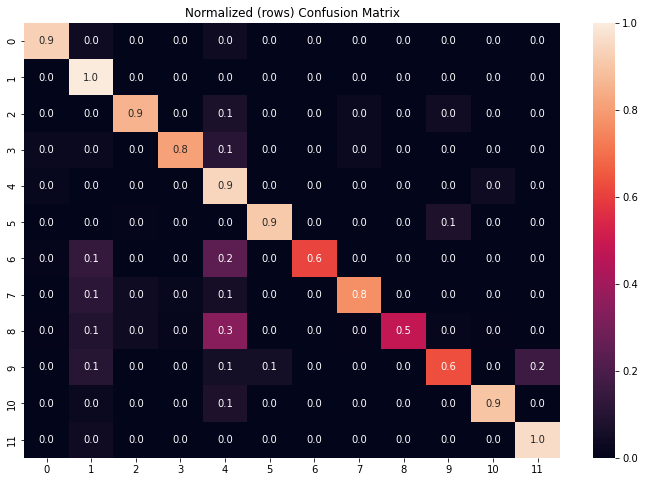

In [70]:
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='.1f')
plt.title('Normalized (rows) Confusion Matrix')

Text(0.5, 1.0, 'Normalized (pred) Confusion Matrix')

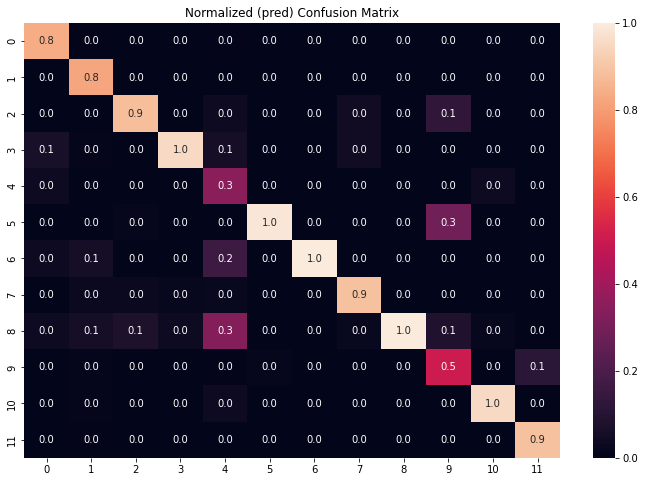

In [71]:
cm = confusion_matrix(targets2, preds2, normalize='pred')
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='.1f')
plt.title('Normalized (pred) Confusion Matrix')